In [138]:
import tensorflow as tf

In [237]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

def plot_quantile_compare1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("t(s)")
    plt.plot(x,y,'.',color='c')
    plt.show()
    
def plot_quantile_compare2(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[2]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    plt.show()
    
    
def plot_quantile_compare_perf1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            time = float(line.split()[1])
            cost = float(line.split()[2])
            y.append((cost/time)*1e-9)
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    plt.show()

### Visualizing the dataset

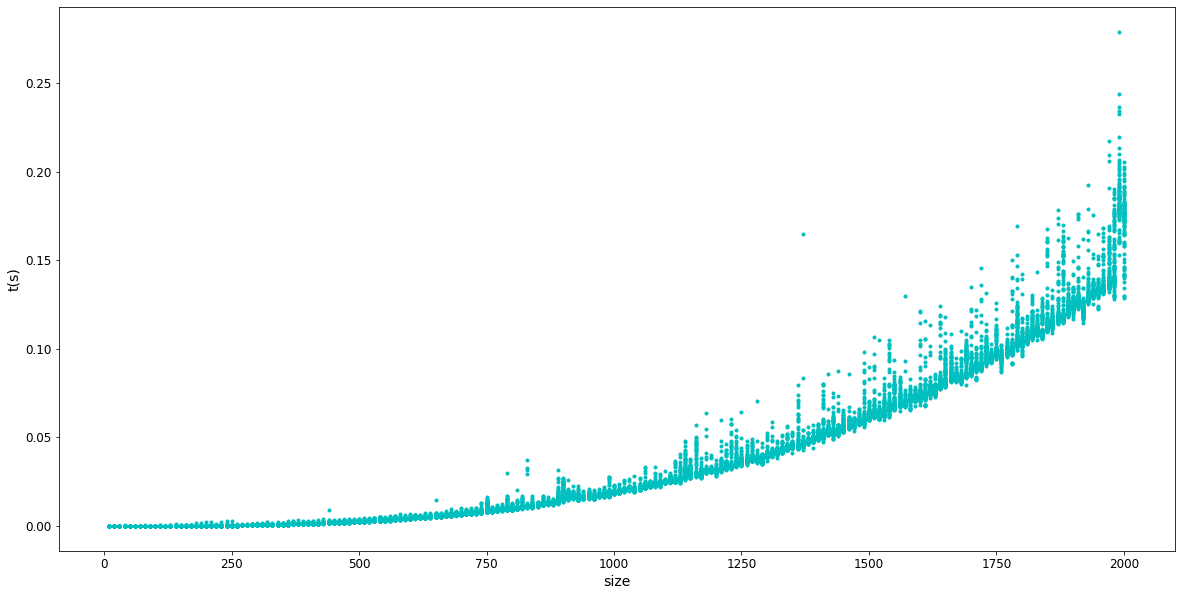

In [63]:
#plt.yscale('log')
plot_quantile_compare1("data/gemm2000.txt")

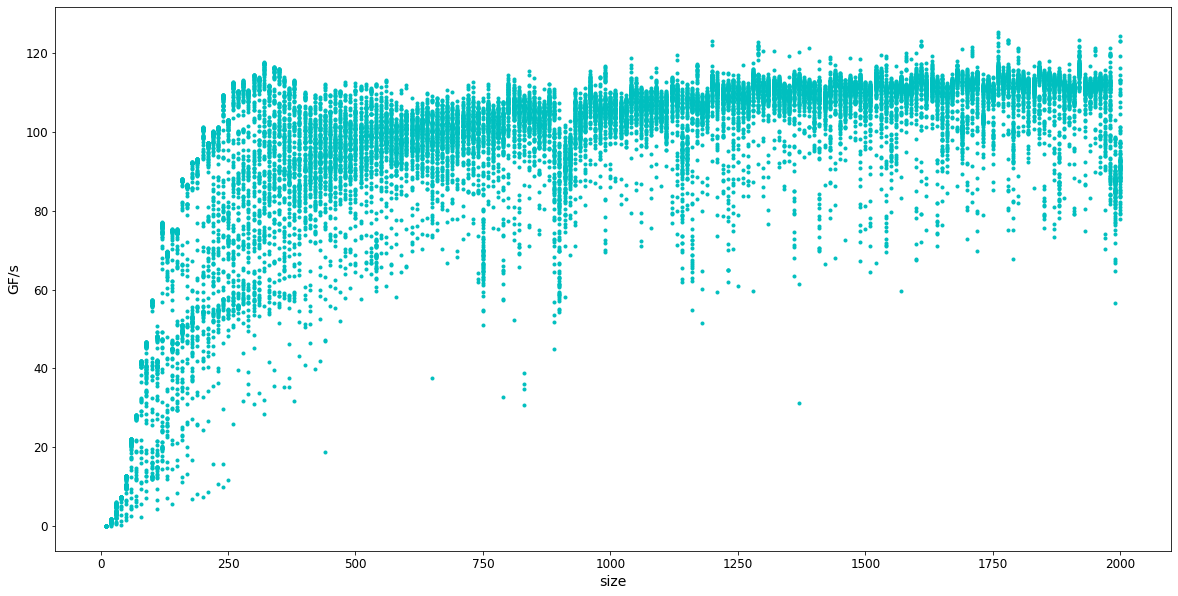

In [64]:
plot_quantile_compare_perf1("data/gemm2000.txt")

### Shuffle dataset

In [65]:
import random

def shuffle_data(log):
    fw = open(log.split(".")[0] + "_shuffled.txt", "w")
    with open(log) as f:
        lines = f.readlines()
        random.shuffle(lines)
        for line in lines:
            fw.write(line)
    fw.close()

In [66]:
shuffle_data("data/gemm2000.txt")

### tf.data API

In [222]:
def cast_to_number(x):
    return tf.strings.to_number(x,out_type=tf.float64)

def split_features_labels(x):
    nn_input = x[0]
    nn_gt = x[2]
    return (nn_input[...,tf.newaxis], nn_gt[...,tf.newaxis])

In [223]:
#filename = "data/gemm2000_shuffled.txt"
filename = "data/gemm2000_shuffled_timeperf_std.txt"
ds_file = tf.data.TextLineDataset(filename)
ds_file = ds_file.map(tf.strings.split)
ds_file = ds_file.map(cast_to_number)
ds_file = ds_file.map(split_features_labels)

### Splitting dataset

In [224]:
DATASET_SIZE = len(open(filename).readlines())

In [225]:
DATASET_SIZE

20000

In [226]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = ds_file.take(train_size)
test_dataset = ds_file.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

**Iterator**

In [227]:
train_dataset = train_dataset.batch(5)
it = iter(train_dataset)

**Sample point**

In [228]:
x = next(it)
x

(<tf.Tensor: id=351485, shape=(5, 1), dtype=float64, numpy=
 array([[1370.],
        [ 580.],
        [ 970.],
        [1550.],
        [1620.]])>, <tf.Tensor: id=351486, shape=(5, 1), dtype=float64, numpy=
 array([[0.46376611],
        [0.00382433],
        [0.34930906],
        [0.54793242],
        [0.60669791]])>)

### Neural Network

>$f = W_2\phi(W_1x)$

In [229]:
tf.keras.backend.set_floatx('float64')

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(None,))
    self.d2 = tf.keras.layers.Dense(10, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.d3 = tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

# Create an instance of the model
model = MyModel()

In [78]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [79]:
input_x, gt_y = next(it)

In [80]:
with tf.GradientTape() as tape:
    nn_out = model(input_x)
    loss_out = loss(gt_y, nn_out) 
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [81]:
input_x, gt_y, nn_out, loss_out

(<tf.Tensor: id=58961, shape=(5, 1), dtype=float64, numpy=
 array([[ 260.],
        [1730.],
        [1650.],
        [  20.],
        [ 760.]])>, <tf.Tensor: id=58962, shape=(5, 1), dtype=float64, numpy=
 array([[3.136000e+00],
        [1.105282e+03],
        [7.920530e+02],
        [1.290000e-01],
        [8.554800e+01]])>, <tf.Tensor: id=59043, shape=(5, 1), dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])>, <tf.Tensor: id=59065, shape=(), dtype=float64, numpy=371264.90625>)

In [175]:
len(gradients) ## W!, B1, W2, B2

4

In [32]:
test_dataset = test_dataset.batch(1)
it_test = iter(test_dataset)

In [33]:
a,b = next(it_test)

In [34]:
a

<tf.Tensor: id=12432, shape=(1, 2), dtype=float64, numpy=array([[1.2400e+03, 1.5376e+06]])>

In [35]:
nn_out = model(a)

In [36]:
nn_out

<tf.Tensor: id=12443, shape=(1, 1), dtype=float64, numpy=array([[0.]])>

### Wrap up

In [230]:
model = MyModel()
loss = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.RMSprop(0.0001)
#optimizer = tf.keras.optimizers.Adam()
mean_loss = tf.keras.metrics.Mean(name='mean_loss')

@tf.function
def train_step(x,gt):
    with tf.GradientTape() as tape:
        nn_out = model(x)
        loss_out = loss(gt, nn_out) 
        reg_loss = tf.math.add_n(model.losses)
        loss_out = loss_out + reg_loss
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    mean_loss(loss_out)

In [231]:
def train_model():
    i = 0
    for input_x, gt_y in train_dataset:
        i = i+1
        train_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss.result()))
            mean_loss.reset_states()

In [244]:

train_model()

Iter 100, Loss: 0.4433510268995189
Iter 200, Loss: 0.4652513496859874
Iter 300, Loss: 0.5016997774806807
Iter 400, Loss: 0.4983546353746206
Iter 500, Loss: 0.4548779956561255
Iter 600, Loss: 0.47963243829037067
Iter 700, Loss: 0.4624762974149163
Iter 800, Loss: 0.44943648405466446
Iter 900, Loss: 0.4738406989575641
Iter 1000, Loss: 0.48521717366061234
Iter 1100, Loss: 0.4819429644902321
Iter 1200, Loss: 0.46689165251794196
Iter 1300, Loss: 0.4817535662391384
Iter 1400, Loss: 0.44845028909330464
Iter 1500, Loss: 0.5001349661617911
Iter 1600, Loss: 0.4455019746429538
Iter 1700, Loss: 0.4333553257358773
Iter 1800, Loss: 0.44927733934197206
Iter 1900, Loss: 0.4714665979408288
Iter 2000, Loss: 0.46497394223399496
Iter 2100, Loss: 0.46197235449365187
Iter 2200, Loss: 0.43760463741556604
Iter 2300, Loss: 0.45884544504571173
Iter 2400, Loss: 0.4830018934252383
Iter 2500, Loss: 0.47620207047976665
Iter 2600, Loss: 0.4487281590463188
Iter 2700, Loss: 0.4774247336983445
Iter 2800, Loss: 0.4578346

In [29]:
mean_loss_test = tf.keras.metrics.Mean(name='mean_loss_test')

@tf.function
def test_step(x, gt):
    nn_out = model(x)
    test_loss = loss(gt, nn_out)

    mean_loss_test(test_loss)
    
    return nn_out

In [30]:
def test_model():
    i = 0
    for input_x, gt_y in test_dataset:
        i = i+1
        result = test_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss_test.result()))
            print(input_x.numpy(), result.numpy(), gt_y.numpy())
        mean_loss_test.reset_states()

In [37]:
test_model()

Iter 100, Loss: 119.79499816894531
[[   830. 688900.]] [[0.]] [[119.795]]
Iter 200, Loss: 340.4159851074219
[[1.2200e+03 1.4884e+06]] [[0.]] [[340.416]]
Iter 300, Loss: 61.887001037597656
[[   680. 462400.]] [[0.]] [[61.887]]
Iter 400, Loss: 42.472999572753906
[[   590. 348100.]] [[0.]] [[42.473]]
Iter 500, Loss: 84.2249984741211
[[   760. 577600.]] [[0.]] [[84.225]]
Iter 600, Loss: 732.8790283203125
[[1.5900e+03 2.5281e+06]] [[0.]] [[732.879]]
Iter 700, Loss: 491.5
[[1.4300e+03 2.0449e+06]] [[0.]] [[491.5]]
Iter 800, Loss: 1.2380000352859497
[[  120. 14400.]] [[0.]] [[1.238]]
Iter 900, Loss: 449.5570068359375
[[1.3400e+03 1.7956e+06]] [[0.]] [[449.557]]
Iter 1000, Loss: 167.1580047607422
[[   990. 980100.]] [[0.]] [[167.158]]
Iter 1100, Loss: 409.7349853515625
[[1.30e+03 1.69e+06]] [[0.]] [[409.735]]
Iter 1200, Loss: 641.7940063476562
[[1.2500e+03 1.5625e+06]] [[0.]] [[641.794]]
Iter 1300, Loss: 1129.0419921875
[[1.8300e+03 3.3489e+06]] [[0.]] [[1129.042]]
Iter 1400, Loss: 252.1990051

### Eval

In [127]:
eval_size = 250
inp = tf.constant(eval_size,shape=(1,1),dtype="float64")
out = model(inp)

In [128]:
out

<tf.Tensor: id=157203, shape=(1, 1), dtype=float64, numpy=array([[0.]])>

In [164]:
import numpy as np

In [250]:
sizes = np.arange(10,2110,5)

In [251]:
y = []
for s in sizes:
    inp = tf.constant(s,shape=(1,1),dtype="float64")
    y.append((model(inp).numpy().reshape(-1)))

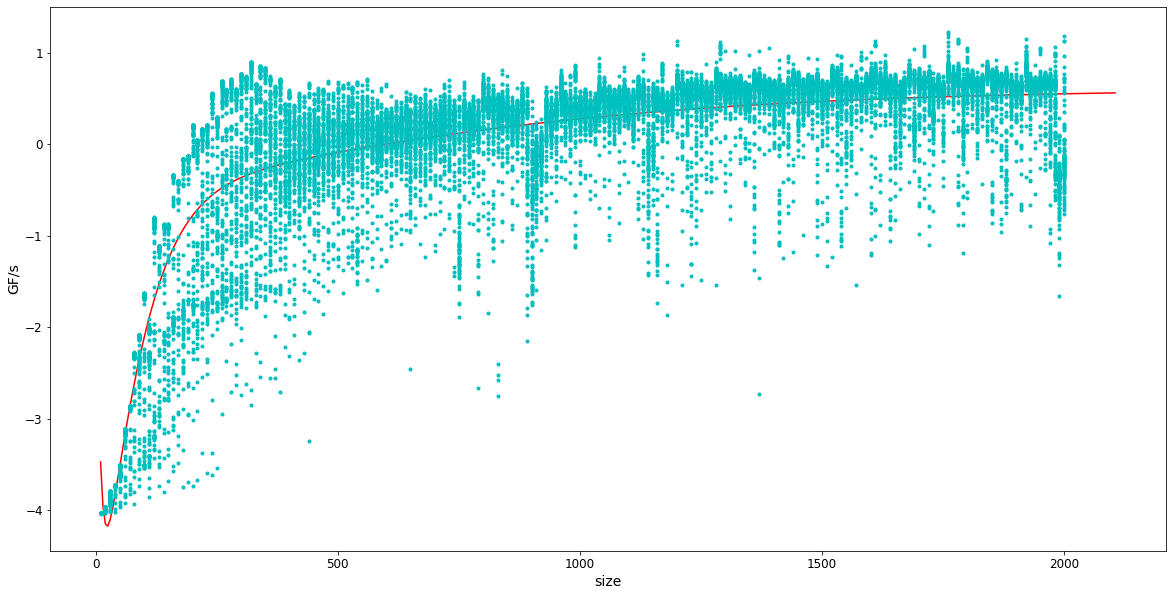

In [254]:
#plt.yscale('log')
plt.plot(sizes,y,color='r')
plot_quantile_compare2("data/gemm2000_shuffled_timeperf_std.txt")


In [49]:
model.losses

[<tf.Tensor: id=30240, shape=(), dtype=float64, numpy=0.0009240008672886935>,
 <tf.Tensor: id=30248, shape=(), dtype=float64, numpy=0.0163728455646859>,
 <tf.Tensor: id=30256, shape=(), dtype=float64, numpy=0.0010061354018645972>]

In [58]:
model.d1.get_weights()

[array([[ 6.08729164e-03,  7.59114746e-14, -2.32924505e-03,
          1.03709691e-02, -5.32105909e-01, -5.22851956e-04,
          9.63299489e-04,  3.28497873e-03,  1.66199233e-03,
         -3.75097116e-17, -5.29155702e-01,  1.49640108e-12,
         -5.56517483e-03,  1.22961834e-04, -2.17526740e-05,
         -4.57074901e-04, -7.91471155e-05,  1.33451651e-02,
         -7.92874324e-04, -7.95096942e-04,  6.35324188e-07,
          2.28760405e-02,  5.89657200e-03,  4.74609871e-07,
          2.72231483e-02,  1.89721156e-02,  2.39591032e-04,
          3.66205751e-02, -4.77892489e-21,  9.97661489e-23,
         -8.50875183e-03, -8.01328692e-03,  4.05601582e-03,
         -5.50505461e-05,  3.90161806e-03,  6.27646006e-03,
          4.21753702e-02,  9.59371841e-03,  6.27860050e-05,
         -3.07724407e-01, -5.32399603e-01,  8.50604968e-03,
          3.25509280e-02, -3.46334851e-04, -9.64410050e-21,
          8.99896016e-03, -5.93478013e-04,  3.54504006e-04,
         -5.71441305e-05,  1.56111788e-0